In [1]:
using AlfvenDetectors
using PyPlot
using BSON
using Flux
using ValueHistories
using StatsBase
using Random

In [2]:
using PyCall
umap = pyimport("umap")

PyObject <module 'umap' from '/home/vit/anaconda3/lib/python3.7/site-packages/umap/__init__.py'>

In [3]:
# include the eval utilities code
adpath = dirname(dirname(pathof(AlfvenDetectors)))
include(joinpath(adpath, "experiments/eval_utils.jl"))

pretty_params

In [4]:
modelpath = "/home/vit/vyzkum/alfven/experiments/conv_old_library/uprobe/"

"/home/vit/vyzkum/alfven/experiments/conv_old_library/uprobe/"

In [9]:
datapath = "/home/vit/vyzkum/alfven/cdb_data/uprobe_data/"
labeled_shots, shot_labels = AlfvenDetectors.labeled_data()
Random.seed!(123)
iused = sample(1:size(labeled_shots,1), 10, replace=false)
labeled_shots = labeled_shots[iused]
shot_labels = shot_labels[iused]
datafiles = readdir(datapath);
println("$(length(datafiles)) shots available")

1028 shots available


In [10]:
patchsize = 128
readfun = AlfvenDetectors.readnormlogupsd
data_labels = []
data_shotnos = []
data = Array{Float32,4}(undef,patchsize,patchsize,1,0)
for (label, shot) in zip(shot_labels, labeled_shots)
    file = joinpath.(datapath, datafiles[map(x->occursin("$shot", x),datafiles)])
    X = AlfvenDetectors.collect_conv_signals(file, readfun, patchsize)
    N = size(X,4)
    data = cat(data,X,dims=4)
    push!(data_labels, fill(label,N))
    push!(data_shotnos, fill(shot,N))
end
data_labels = vcat(data_labels...);
data_shotnos = vcat(data_shotnos...);

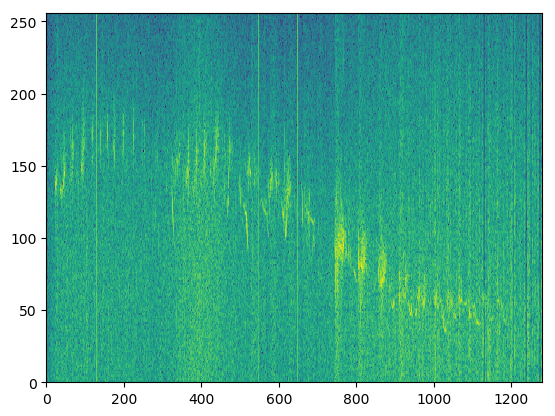

(128, 128, 1, 20)

In [11]:
testdata = readfun(joinpath(datapath, "uprobe_10893.h5"));
testdata = testdata[129:384, 1537:2816]
figure()
pcolormesh(testdata)
testdata = AlfvenDetectors.split_reshape(testdata,patchsize);
size(testdata)

In [13]:
mf = joinpath(modelpath, "batchnorm-test/ConvAE_xdim-(128, 128, 1)_ldim-64_nlayers-2_kernelsize-3_channels-[2, 4]_scaling-2_batchnorm-true_batchsize-128_nepochs-1000_opt-RMSProp_eta-0.001_usegpu-true_memoryefficient-true_2019-04-05T17:03:35.079.bson")
# this is the best model, however it was trained on the 10893 data
#mf = joinpath(modelpath, "outbatchnorm/ConvAE_xdim-(128, 128, 1)_ldim-64_nlayers-2_kernelsize-3_channels-[2, 4]_scaling-2_outbatchnorm-false_batchnorm-true_batchsize-128_nepochs-1000_opt-RMSProp_eta-0.001_usegpu-true_memoryefficient-true_2019-04-11T22:20:35.763.bson")
#mf = joinpath(modelpath, "outbatchnorm/ConvAE_xdim-(128, 128, 1)_ldim-64_nlayers-2_kernelsize-3_channels-[2, 4]_scaling-2_outbatchnorm-true_batchnorm-true_batchsize-128_nepochs-1000_opt-RMSProp_eta-0.001_usegpu-true_memoryefficient-true_2019-04-11T20:12:06.821.bson")
model_data = BSON.load(mf)
params = parse_params(mf)
hist = model_data[:history]
model = model_data[:model]
if get(params, :batchnorm, false)
    Flux.testmode!(model);
end
display(params)
is,ls = get(hist,:loss)
vl = AlfvenDetectors.loss(model, testdata).data
println("trainig loss: $(ls[end])")
println("validation loss: $vl")

UndefVarError: UndefVarError: ConvTranspose not defined

Check the reconstructions.

In [ ]:
cmap="plasma"
for i in 1:size(testdata,4)
    figure(figsize=(10,5))
    subplot(1,2,1)
    pcolormesh(testdata[:,:,1,i], cmap=cmap)
    subplot(1,2,2)
    pcolormesh(model(testdata[:,:,:,i:i]).data[:,:,1,1], cmap=cmap)
    
end

In [ ]:
testdata

In [ ]:
GC.gc()

In [ ]:
# now compute the code in batches
batchsize = 10
z = model.encoder(data[:,:,:,1:batchsize]).data;
for i in 2:floor(Int,size(data,4)/batchsize)
    z=cat(z, model.encoder(data[:,:,:,((i-1)*batchsize+1):i*batchsize]).data, dims=2)
end
z=cat(z, model.encoder(data[:,:,:,end-(size(data,4)%batchsize)+1:end]).data, dims=2);

In [ ]:
plt.hist(mean(z,dims=2))

In [ ]:
umap_model = umap.UMAP(n_components = 2, n_neighbors=15, min_dist=0.1)

In [ ]:
z2D = Array(umap_model.fit_transform(z')')

In [ ]:
scatter(z2D[1,:],z2D[2,:],s=5)
title("data from shots $(labeled_shots)")

In [ ]:
for shotno in unique(data_shotnos)
    zs = z2D[:,data_shotnos.==shotno]
    scatter(zs[1,:], zs[2,:],s=5,label="$shotno")
end
legend()

In [ ]:
for label in unique(data_labels)
    zs = z2D[:,data_labels.==label]
    scatter(zs[1,:], zs[2,:],s=5,label="$label")
end
legend()

In [ ]:
testz = model.encoder(testdata).data;
testz2D = Array(umap_model.transform(testz')')

In [ ]:
for label in unique(data_labels)
    zs = z2D[:,data_labels.==label]
    scatter(zs[1,:], zs[2,:],s=5,label="$label")
end
scatter(testz2D[1,:], testz2D[2,:],s=5,label="test",c="k")
legend()

In [ ]:
clusterinds = collect(1:size(z2D,2))[ (-50. .< z2D[1,:] .< -10) .&  (-10 .< z2D[2,:] .< 10)]
#clusterinds = collect(1:size(z2D,2))[ (-2. .< z2D[1,:] .< 1) .&  (0 .< z2D[2,:] .< 3)]
#clusterinds = collect(1:size(z2D,2))[ (0.5 .< z2D[1,:] .< 3) .&  (5.5 .< z2D[2,:] .< 6.5)]
scatter(z2D[1,clusterinds],z2D[2,clusterinds])
scatter(testz2D[1,:], testz2D[2,:],s=5,label="test",c="k")


In [ ]:
for i in clusterinds
    figure()
    pcolormesh(data[:,:,1,i], cmap="plasma")
    title("$i, label = $(data_labels[i])")
end

In [ ]:
plt.hist(mean(z,dims=2))

In [ ]:
plt.hist(mean(z[:,clusterinds],dims=2))